#HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


##[TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [ ]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

**[TO COMPLETE]**: What happens varying the ENCODING_DIM? test  and discuss the results in a new cell after the following one.

In [ ]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)

Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [ ]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the second one contains the reconstructions.

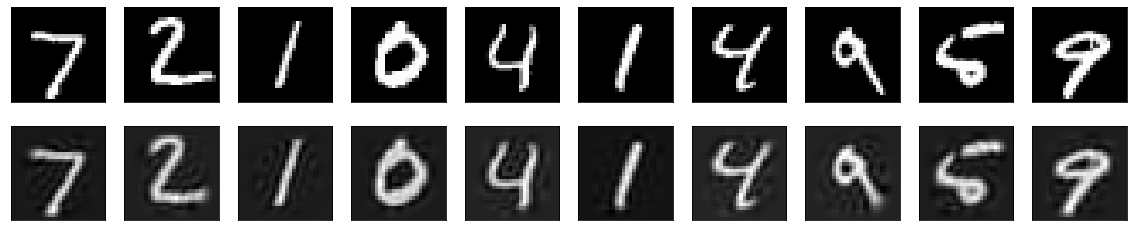

In [ ]:
plot_img(10, x_test, x_test_reco)

Test with different encoding dimensions.

Encoding dimension: 40
Training MSE: 0.01443
Test MSE: 0.01405


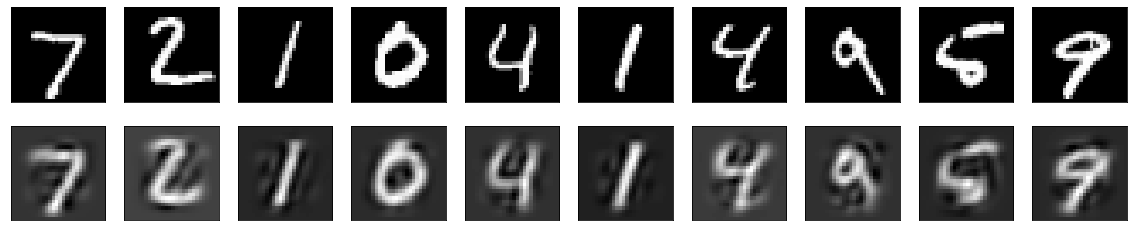

Encoding dimension: 64
Training MSE: 0.00931
Test MSE: 0.00905


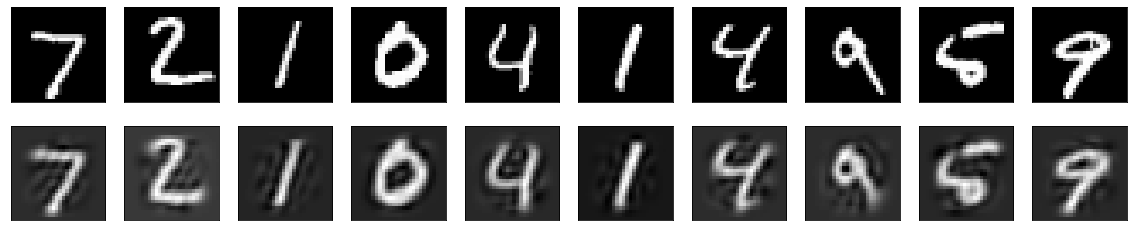

Encoding dimension: 120
Training MSE: 0.00464
Test MSE: 0.00455


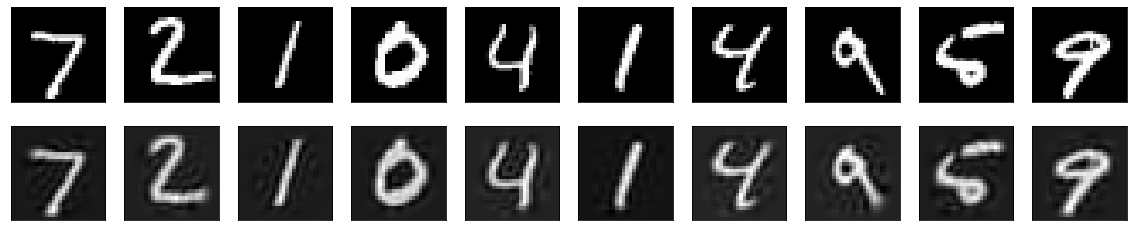

Encoding dimension: 150
Training MSE: 0.00348
Test MSE: 0.00343


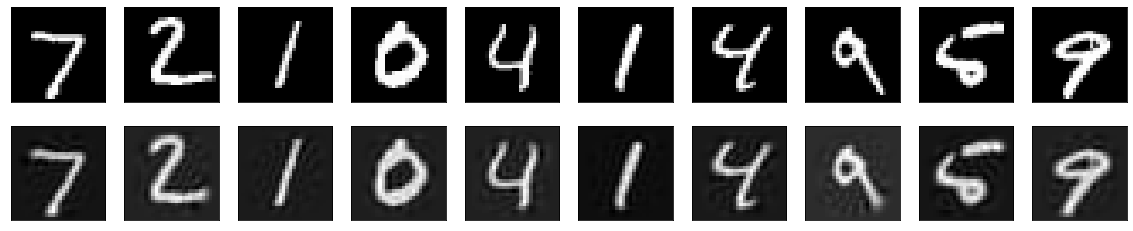

Encoding dimension: 256
Training MSE: 0.00140
Test MSE: 0.00139


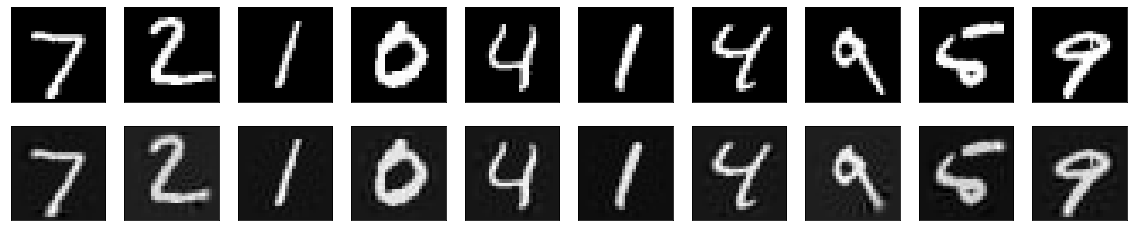

In [ ]:
encoding_dimensions = [40, 64, 120, 150, 256]

for encoding_dim in encoding_dimensions:

  U_k = svd_k(x_train, encoding_dim)

  x_training_pca = np.dot(x_train, U_k)
  x_test_pca = np.dot(x_test, U_k)

  x_training_reco = np.dot(x_training_pca, U_k.T)
  x_test_reco = np.dot(x_test_pca, U_k.T)

  accuracy_train = ((x_train - x_training_reco)**2).mean()
  accuracy_test = ((x_test - x_test_reco)**2).mean()

  print('Encoding dimension: {}'.format(str(encoding_dim)))
  print("Training MSE: %.5f" % (accuracy_train))
  print("Test MSE: %.5f" % (accuracy_test))

  plot_img(10, x_test, x_test_reco)

From the results obtained above, we can see that the larger the encoding size, the better the image reconstruction. With a small encoding dimension, matrices are smaller than those with a larger encoding dimension. This implies that the time required for the excution is less.

The disadvantage of using a small encoding dimension is that it keeps a narrow set of the most important information useful for reconstructing the images in the decompression phase. Indeed, we can see that the MSE (training and test) are bigger than those with a larger encoding dimension. The images are also more blurry with a small encoding dimension.

With a larger encoding dimension, the training and test MSE are smaller and the images are more defined and similar to the original ones. In this way, the larger encoding dimension allows to keep more important information useful for reconstructing the image.

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

**[TO COMPLETE]** check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 3s 21ms/step - loss: 0.1028 - val_loss: 0.0163
Epoch 2/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0143 - val_loss: 0.0101
Epoch 3/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 4/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 5/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 6/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 7/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 8/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 9/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 10/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [9]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0048
test mse: 0.00483


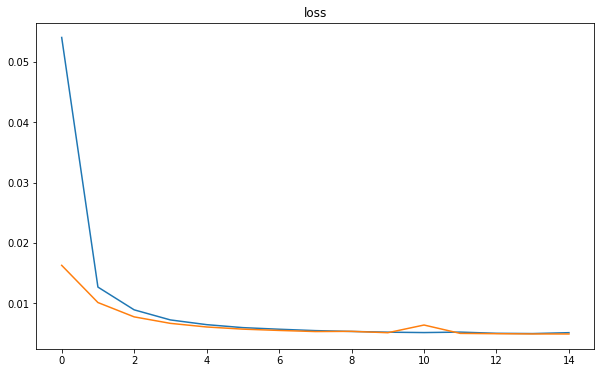

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

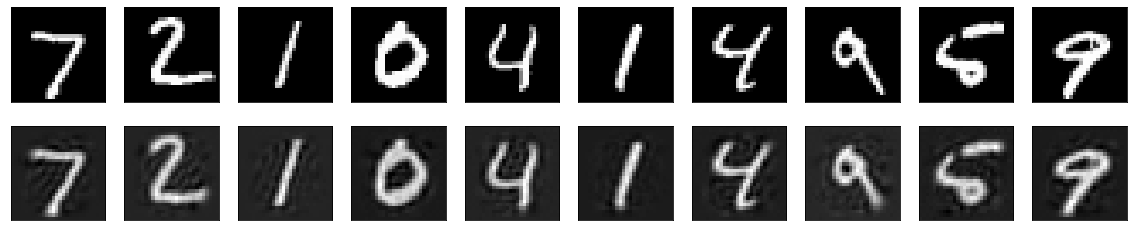

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

Results (test MSE):
* **SVD**: 0.00455
* **Shallow Linear Autoencoder**: 0.00483

The results are very similar because the two approaches have the same goal to reach. The similarity can be noticed even from the images reconstructed by the two approaches.

**Proof that SVD and shallow linear autoencoder are equivalent**

Given a shallow feed-forward network (with only one hidden layer) and a linear activation function $f(x) = x$, the output $o$ will be:
$$
o = W_o \cdot W_i \cdot x
$$
where:
* $x$ is the input;
* $W_i$ is the matrix of weights from the input layer to the hidden layer;
* $W_o$ is the matrix of weights from the hidden layer to the output layer.

From the fact that $o = x$, we can say that $x = W_o \cdot W_i \cdot x$. So, $W_i = W_o^T$. The encoding of the input is the output of the hidden layer, so we have: $encoder(x) = W_i \cdot x$. Starting from that, the reconstruction of the image is done in this way: $x^r = W_o \cdot encoder(x) = W_i^T \cdot encoder(x)$.

For the SVD we have:
* $encoder(x) = U \cdot x$ and
* the reconstructed image is $x^r = U^T \cdot encoder(x)$.

If we consider $U = W_i$, we can see that SVD and shallow linear autoencoder are equivalent.

##[TO COMPLETE] Exercise 5.3: Shallow non-linear autoencoders

**[TO COMPLETE]** replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. (Insert your code and  theoretical discussion into  cells immediately below this one.)


In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_25 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0752 - val_loss: 0.0347
Epoch 2/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0313 - val_loss: 0.0221
Epoch 3/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0205 - val_loss: 0.0160
Epoch 4/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0153 - val_loss: 0.0127
Epoch 5/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0121 - val_loss: 0.0106
Epoch 6/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0102 - val_loss: 0.0092
Epoch 7/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 8/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0079 - val_loss: 0.0072
Epoch 9/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 10/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 11/

313/313 - 0s - loss: 0.0043
test mse: 0.00432


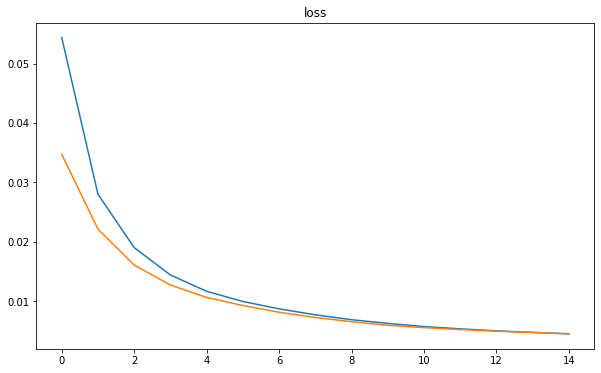

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

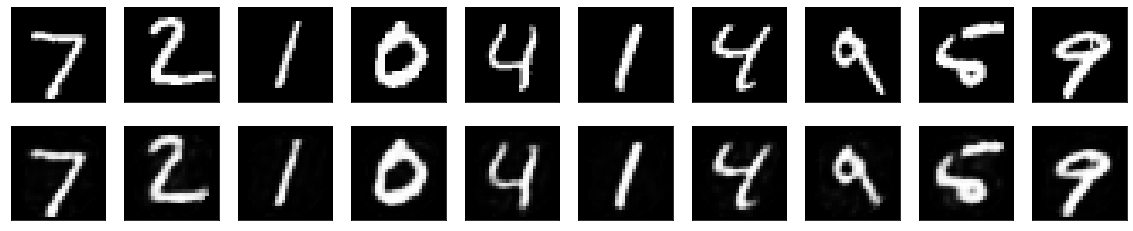

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

Results:
* **Shallow Linear Autoencoder**: 0.00483
* **Shallow Non-Linear Autoencoder**: 0.00432

From the reconstructed images, we can see that there has been an improvement. The non-linear autoencoder has reached a lower test MSE than the linear autoencoder. We can see that the images are more defined and the background is similar to the original images. Using a non-linear activation function allows to detect better the most important features and to avoid the noise in the data. These features are encoded in the *latent space*, where similar data points are closer together. This is an advantage because in the reconstruction phase, the network is able to rebuild the images better than the network with a linear activation function.

In this model, I used the *sigmoidal* function. It is a differentiable and continuous function that gives in output a value between $0$ and $1$. I used this acrivation function because we don't want to interpret the output as a probability: the task is not to classify the input. The task is to reproduce the input in output. The sigmoidal function predicts the values for the pixels of the output images. 

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
ENCODING_DIM = 64

input_img = tf.keras.layers.Input(shape=(784,))

encoded_1 = tf.keras.layers.Dense(256, activation='sigmoid')(input_img)
encoded_2 = tf.keras.layers.Dense(128, activation='tanh')(encoded_1)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='tanh')(encoded_2)

decoded_1 = tf.keras.layers.Dense(128, activation='tanh')(encoded)
decoded_2 = tf.keras.layers.Dense(256, activation='tanh')(decoded_1)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded_2)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               2014

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=128, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
391/391 [==============================] - 6s 14ms/step - loss: 0.0780 - val_loss: 0.0412
Epoch 2/15
391/391 [==============================] - 5s 13ms/step - loss: 0.0362 - val_loss: 0.0253
Epoch 3/15
391/391 [==============================] - 5s 13ms/step - loss: 0.0235 - val_loss: 0.0180
Epoch 4/15
391/391 [==============================] - 5s 13ms/step - loss: 0.0172 - val_loss: 0.0143
Epoch 5/15
391/391 [==============================] - 5s 13ms/step - loss: 0.0139 - val_loss: 0.0119
Epoch 6/15
391/391 [==============================] - 5s 13ms/step - loss: 0.0116 - val_loss: 0.0103
Epoch 7/15
391/391 [==============================] - 5s 13ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 8/15
391/391 [==============================] - 5s 13ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 9/15
391/391 [==============================] - 5s 13ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 10/15
391/391 [==============================] - 5s 14ms/step - loss: 0.0076 - val_lo

313/313 - 1s - loss: 0.0054
test mse: 0.00544


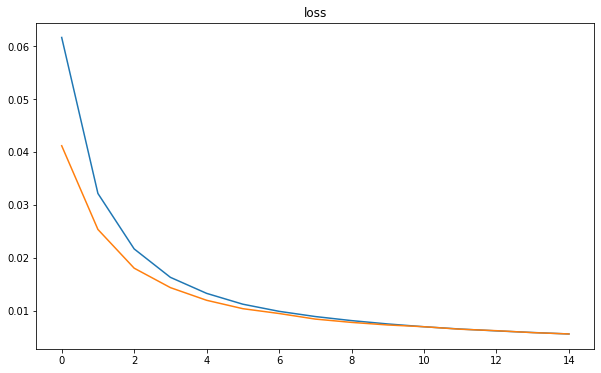

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

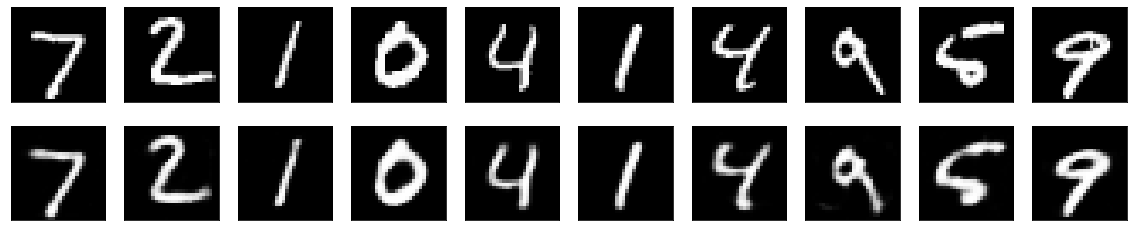

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder. **NOTE: in the code at the bottom noise_factor is added and not multiplied for numerical reasons. You may want to try the version with multiplication to verify it is more unstable.**

**Multiplication version**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

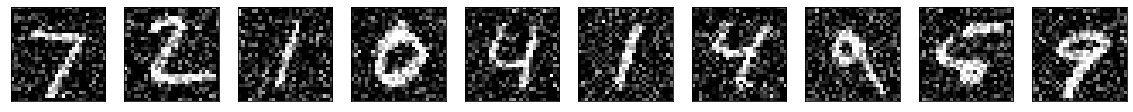

In [ ]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [ ]:
ENCODING_DIM = 300

input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_15 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_16 (Dense)             (None, 784)               235984    
Total params: 471,484
Trainable params: 471,484
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_valid_noisy, x_valid))#[TO COMPLETE]

Epoch 1/20
391/391 [==============================] - 6s 14ms/step - loss: 0.0699 - val_loss: 0.0305
Epoch 2/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0270 - val_loss: 0.0190
Epoch 3/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0177 - val_loss: 0.0143
Epoch 4/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0136 - val_loss: 0.0120
Epoch 5/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 6/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 7/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 8/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 9/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 10/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0077 - val_lo

313/313 - 1s - loss: 0.0068
test mse: 0.00681


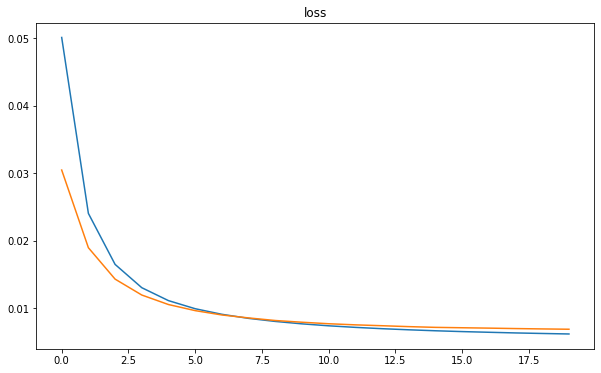

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

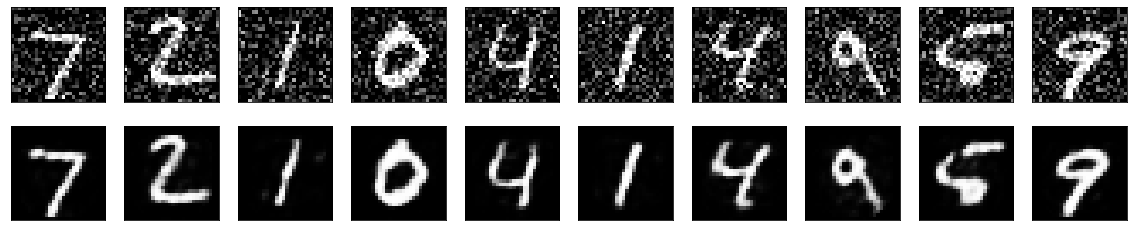

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

Noise factor: 0.4

Epoch 1/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0671 - val_loss: 0.0285
Epoch 2/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0256 - val_loss: 0.0194
Epoch 3/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0182 - val_loss: 0.0158
Epoch 4/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0151 - val_loss: 0.0141
Epoch 5/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 6/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0125 - val_loss: 0.0126
Epoch 7/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0118 - val_loss: 0.0122
Epoch 8/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0112 - val_loss: 0.0119
Epoch 9/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0108 - val_loss: 0.0117
Epoch 10/20
391/391 [==============================] - 5s 12ms/step - lo

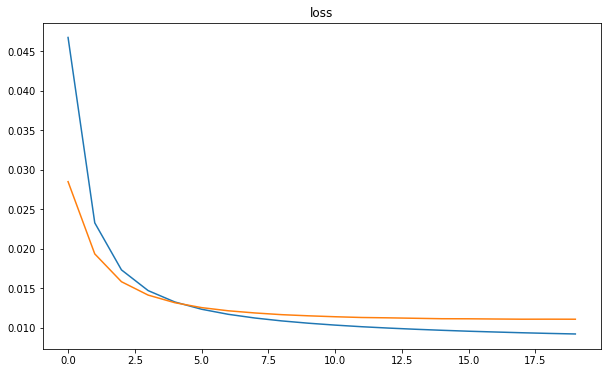

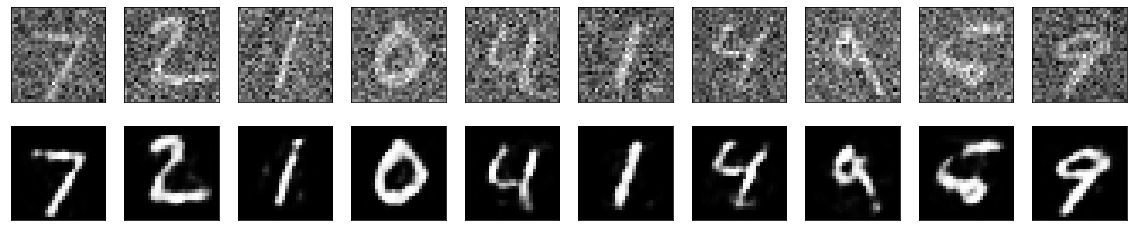


Noise factor: 0.6

Epoch 1/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0683 - val_loss: 0.0315
Epoch 2/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0292 - val_loss: 0.0241
Epoch 3/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0230 - val_loss: 0.0214
Epoch 4/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0204 - val_loss: 0.0201
Epoch 5/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0190 - val_loss: 0.0194
Epoch 6/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0181 - val_loss: 0.0189
Epoch 7/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0174 - val_loss: 0.0186
Epoch 8/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0169 - val_loss: 0.0184
Epoch 9/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0165 - val_loss: 0.0182
Epoch 10/20
391/391 [==============================] - 5s 13ms/step - l

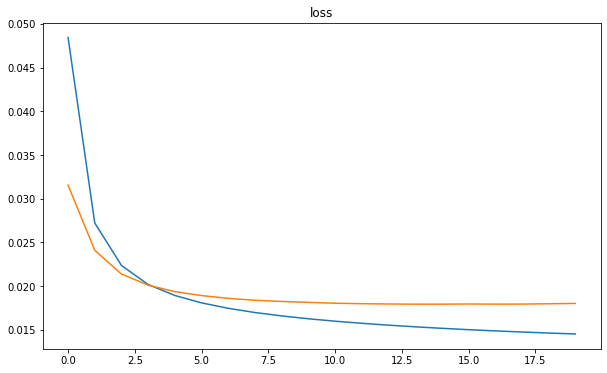

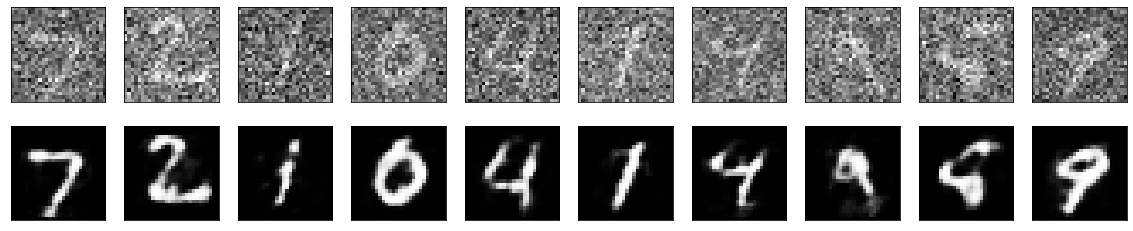


Noise factor: 0.8

Epoch 1/20
391/391 [==============================] - 6s 14ms/step - loss: 0.0696 - val_loss: 0.0354
Epoch 2/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0331 - val_loss: 0.0291
Epoch 3/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0280 - val_loss: 0.0270
Epoch 4/20
391/391 [==============================] - 5s 14ms/step - loss: 0.0257 - val_loss: 0.0259
Epoch 5/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0244 - val_loss: 0.0253
Epoch 6/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0234 - val_loss: 0.0249
Epoch 7/20
391/391 [==============================] - 5s 14ms/step - loss: 0.0228 - val_loss: 0.0247
Epoch 8/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0222 - val_loss: 0.0245
Epoch 9/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0217 - val_loss: 0.0245
Epoch 10/20
391/391 [==============================] - 5s 13ms/step - l

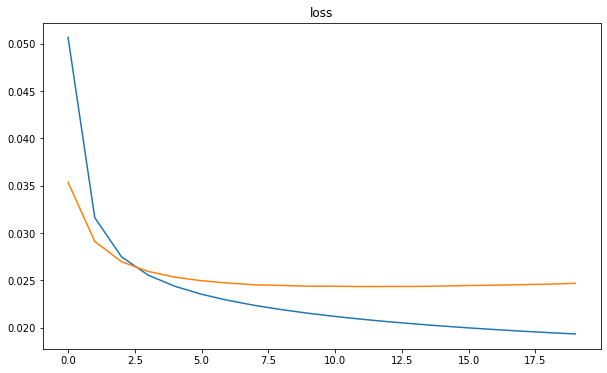

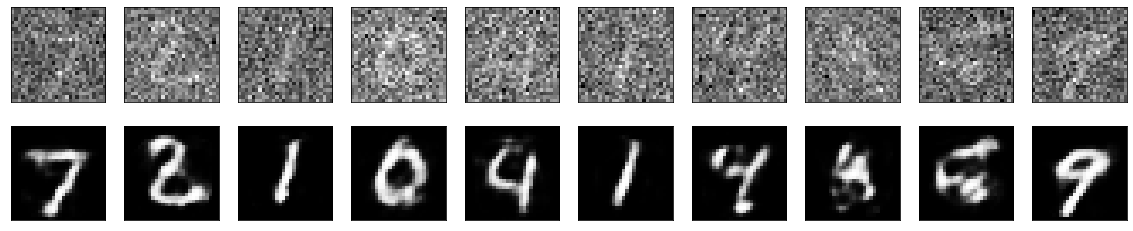

In [ ]:
n = 10
ENCODING_DIM = 300
noise_factors = [0.4, 0.6, 0.8]

for noise_factor in noise_factors:
  print('Noise factor: {}'.format(str(noise_factor)))
  print()

  x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
  x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
  x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

  input_img = tf.keras.layers.Input(shape=(784,))
  encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
  decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

  autoencoder = tf.keras.models.Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='mse')

  history = autoencoder.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_valid_noisy, x_valid))

  plot_loss(history)
  scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
  print("test mse: %.5f" % (scores))

  decoded_imgs = autoencoder.predict(x_test_noisy)
  plot_img(10, x_test_noisy, decoded_imgs)
  print()

**Addition version**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

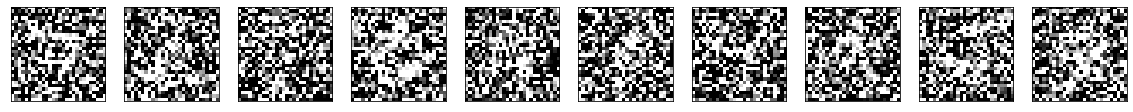

In [ ]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [ ]:
ENCODING_DIM = 300

input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_10 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_valid_noisy, x_valid))#[TO COMPLETE]

Epoch 1/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0758 - val_loss: 0.0512
Epoch 2/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0490 - val_loss: 0.0437
Epoch 3/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0428 - val_loss: 0.0402
Epoch 4/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0394 - val_loss: 0.0381
Epoch 5/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0372 - val_loss: 0.0366
Epoch 6/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0358 - val_loss: 0.0357
Epoch 7/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0346 - val_loss: 0.0351
Epoch 8/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0339 - val_loss: 0.0346
Epoch 9/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0333 - val_loss: 0.0342
Epoch 10/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0327 - val_lo

313/313 - 1s - loss: 0.0326
test mse: 0.03259


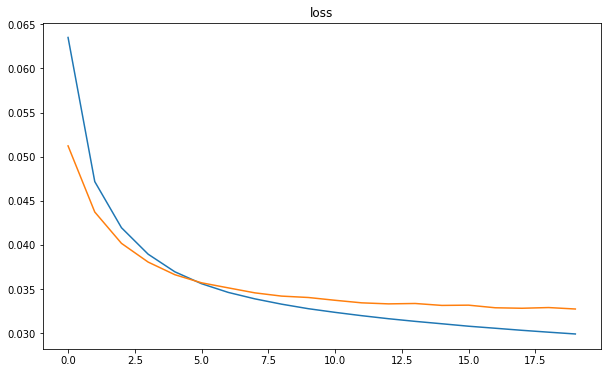

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

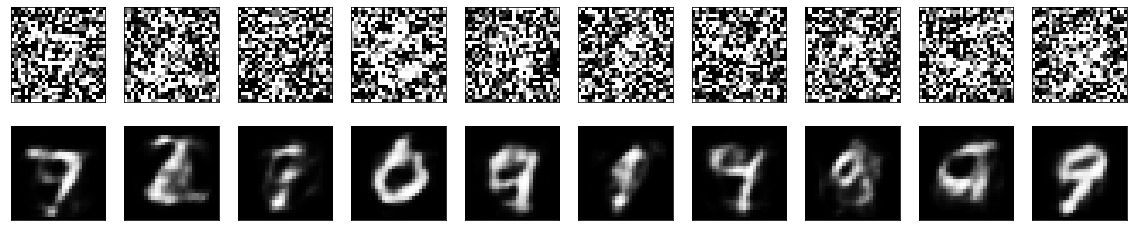

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

Noise factor: 0.4

Epoch 1/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0726 - val_loss: 0.0434
Epoch 2/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0415 - val_loss: 0.0372
Epoch 3/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0361 - val_loss: 0.0344
Epoch 4/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0333 - val_loss: 0.0330
Epoch 5/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0315 - val_loss: 0.0322
Epoch 6/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0304 - val_loss: 0.0316
Epoch 7/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0295 - val_loss: 0.0313
Epoch 8/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0288 - val_loss: 0.0310
Epoch 9/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0282 - val_loss: 0.0309
Epoch 10/20
391/391 [==============================] - 5s 12ms/step - lo

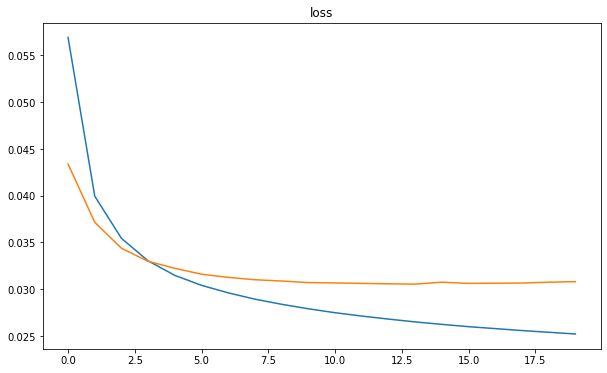

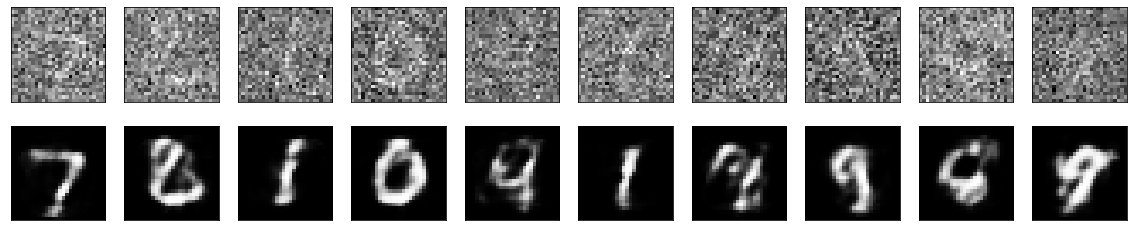


Noise factor: 0.6

Epoch 1/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0734 - val_loss: 0.0447
Epoch 2/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0425 - val_loss: 0.0380
Epoch 3/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0370 - val_loss: 0.0352
Epoch 4/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0341 - val_loss: 0.0336
Epoch 5/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0323 - val_loss: 0.0327
Epoch 6/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0311 - val_loss: 0.0322
Epoch 7/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0301 - val_loss: 0.0316
Epoch 8/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0293 - val_loss: 0.0314
Epoch 9/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0287 - val_loss: 0.0311
Epoch 10/20
391/391 [==============================] - 5s 13ms/step - l

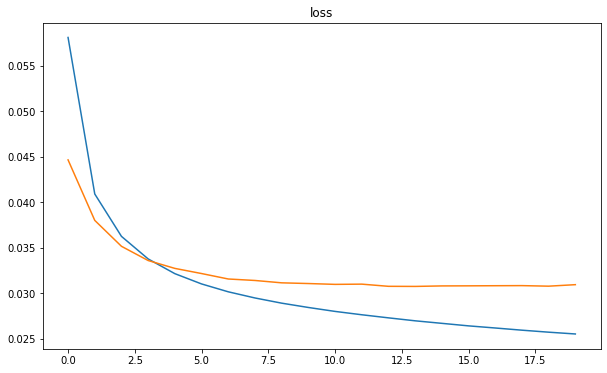

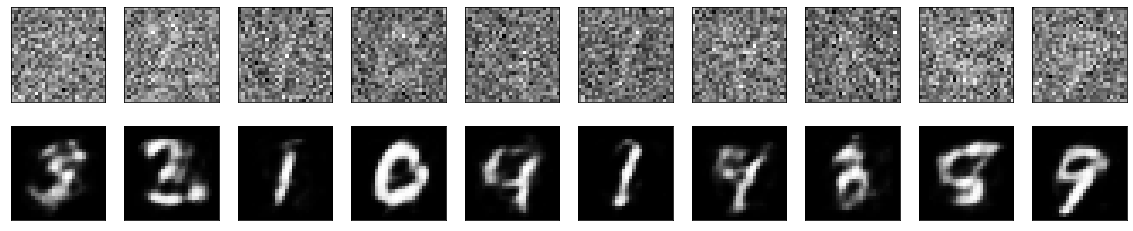


Noise factor: 0.8

Epoch 1/20
391/391 [==============================] - 6s 13ms/step - loss: 0.0735 - val_loss: 0.0465
Epoch 2/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0444 - val_loss: 0.0394
Epoch 3/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0385 - val_loss: 0.0363
Epoch 4/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0354 - val_loss: 0.0346
Epoch 5/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0337 - val_loss: 0.0335
Epoch 6/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0324 - val_loss: 0.0328
Epoch 7/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0313 - val_loss: 0.0322
Epoch 8/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0306 - val_loss: 0.0318
Epoch 9/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0300 - val_loss: 0.0315
Epoch 10/20
391/391 [==============================] - 5s 13ms/step - l

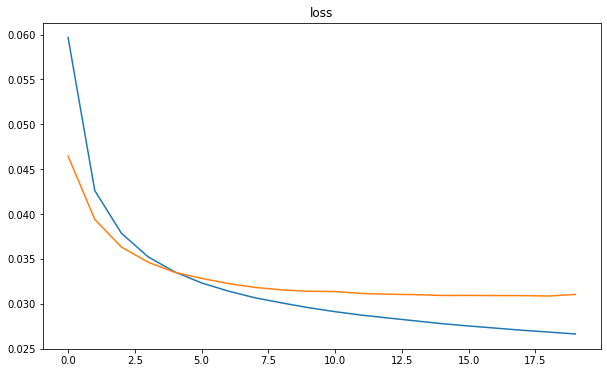

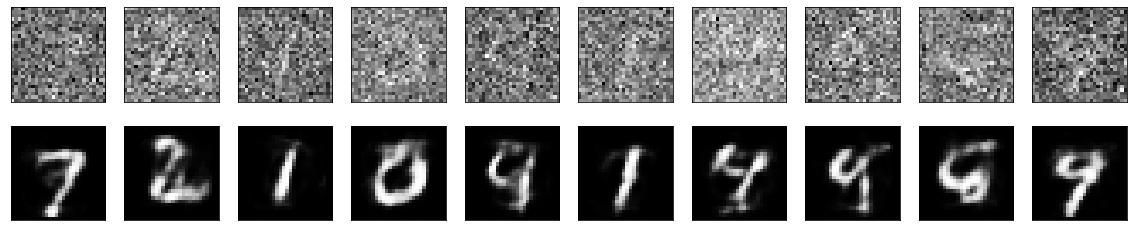

In [ ]:
n = 10
ENCODING_DIM = 300
noise_factors = [0.4, 0.6, 0.8]

for noise_factor in noise_factors:
  print('Noise factor: {}'.format(str(noise_factor)))
  print()

  x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
  x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
  x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

  input_img = tf.keras.layers.Input(shape=(784,))
  encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
  decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

  autoencoder = tf.keras.models.Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='mse')

  history = autoencoder.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_valid_noisy, x_valid))

  plot_loss(history)
  scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
  print("test mse: %.5f" % (scores))

  decoded_imgs = autoencoder.predict(x_test_noisy)
  plot_img(10, x_test_noisy, decoded_imgs)
  print()

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [4]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


1646592/1641221 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [5]:
from keras.utils import to_categorical

X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [6]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 9s 67ms/step - loss: 0.3383 - categorical_accuracy: 0.1438 - val_loss: 0.0858 - val_categorical_accuracy: 0.4629
Epoch 2/50
79/79 [==============================] - 5s 65ms/step - loss: 0.0792 - categorical_accuracy: 0.4859 - val_loss: 0.0715 - val_categorical_accuracy: 0.5051
Epoch 3/50
79/79 [==============================] - 5s 65ms/step - loss: 0.0673 - categorical_accuracy: 0.5282 - val_loss: 0.0643 - val_categorical_accuracy: 0.5408
Epoch 4/50
79/79 [==============================] - 5s 66ms/step - loss: 0.0616 - categorical_accuracy: 0.5570 - val_loss: 0.0588 - val_categorical_accuracy: 0.5664
Epoch 5/50
79/79 [==============================] - 5s 65ms/step - loss: 0.0555 - categorical_accuracy: 0.5806 - val_loss: 0.0509 - val_categorical_accuracy: 0.5991
Epoch 6/50
79/79 [==============================] - 5s 66ms/step - loss: 0.0479 - categorical_accuracy: 0.6143 - val_loss: 0.0427 - val_categorical_accuracy: 0.6477
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0158 - categorical_accuracy: 0.9036
categorical_accuracy: 90.36%


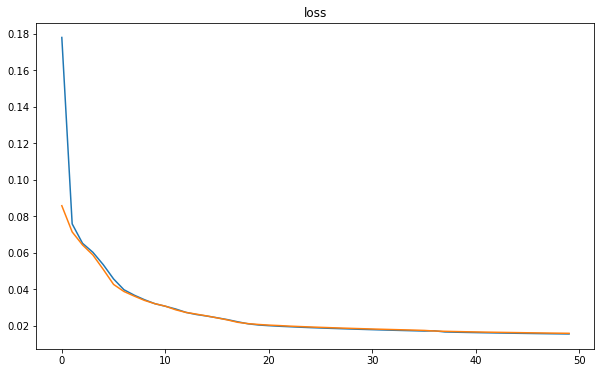

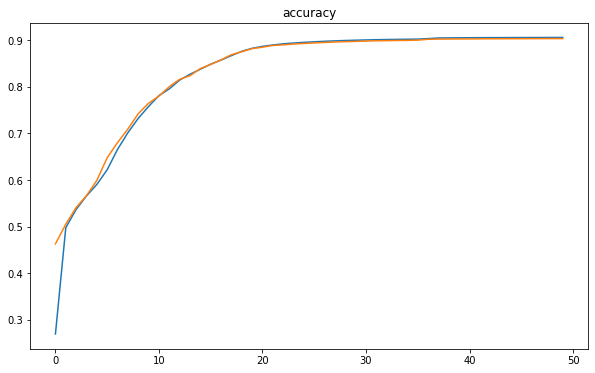

In [10]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [11]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
was a <oov> <oov> that they <oov> in all of that time i that <oov> the <oov> is <oov> a just <oov> film in just has <oov> <oov> <oov> <oov> as some so <oov> and <oov> out it <oov> like <oov> <oov> of the film i <oov> <oov> there <oov> on <oov> <oov> <oov> it <oov> <oov> in the <oov> <oov> this is a really in film that <oov> <oov> <oov> it its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> out <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [13]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 90, 100)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 31s 19ms/step - loss: 0.0491 - categorical_accuracy: 0.3486 - val_loss: 0.0373 - val_categorical_accuracy: 0.4687
Epoch 2/50
79/79 [==============================] - 1s 13ms/step - loss: 0.0364 - categorical_accuracy: 0.4774 - val_loss: 0.0354 - val_categorical_accuracy: 0.4697
Epoch 3/50
79/79 [==============================] - 1s 13ms/step - loss: 0.0341 - categorical_accuracy: 0.4837 - val_loss: 0.0314 - val_categorical_accuracy: 0.4909
Epoch 4/50
79/79 [==============================] - 1s 13ms/step - loss: 0.0300 - categorical_accuracy: 0.4979 - val_loss: 0.0272 - val_categorical_accuracy: 0.5178
Epoch 5/50
79/79 [==============================] - 1s 13ms/step - loss: 0.0257 - categorical_accuracy: 0.5410 - val_loss: 0.0229 - val_categorical_accuracy: 0.5653
Epoch 6/50
79/79 [==============================] - 1s 13ms/step - loss: 0.0214 - categorical_accuracy: 0.6196 - val_loss: 0.0185 - val_categorical_accuracy: 0.7341
Epoch 7/5

40/40 - 0s - loss: 2.6586e-05 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


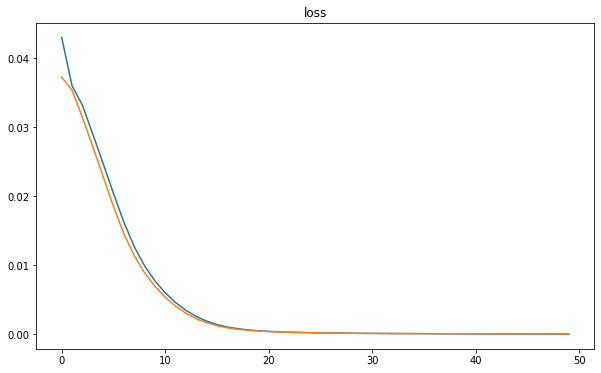

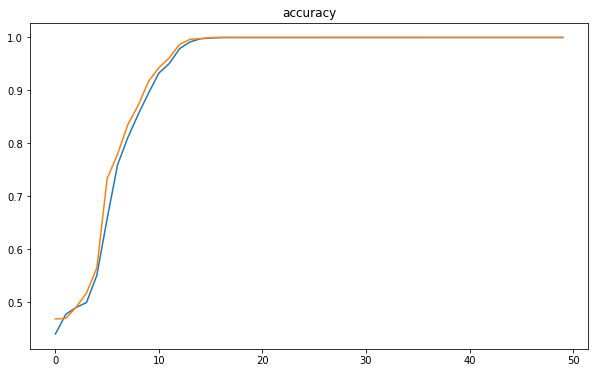

In [15]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [16]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index = np.argmax(decoded_text[500], axis=1)
input_text = np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


Results:
* **Linear Autoencoder**: loss: 0.0065, accuracy: 96.60%;
* **Non-Linear Autoencoder (with *tanh* activation function)**: loss: 2.6586e-05, accuracy: 100%;
* **Non-Linear Autoencoder (with *sigmoid* activation function)**: loss: 3.4105e-05, accuracy: 100%.

The reason why the nonlinear autoencoder achieved better results than the linear autoencoder is the same explained for the shallow linear autoencoder and the shallow nonlinear autoencoder. Using a non-linear activation function allows you to detect more of the most important characteristics than a linear activation function. This is an advantage because the network is able to reconstruct the sentence with greater precision.

For the first model, I chose the *sigmoidal* function because it is a differentiable and a continuous function. It is prone to the *vanishing problem*. Suppose we have a neural netowork with an activation functions such as the sigmoidal. During the backward propagation, the network calculates the gradients based on the *chain rule*. This process implies that the gradient decreases exponentially. The *hyperbolic tangent* is a function that copes better with this problem than the sigmoid. I used this function in the model above. These two functions are similar but they differ in the *first derivative*. When the sigmoid function value is either too high or too low, the first derivative becomes very small. This causes vanishing gradients and this implies a poor learning for deep neural networks. This can occur when the weights of our networks are initialized poorly (with too-large negative and positive values). These too-large values *saturate* the input to the sigmoid and the first derivatives gives small values. However, even if the weights are initialized nicely, the first derivative return values around the maximum ($0.2$). Therefore, a large change in the input of the sigmoid function will cause a small change in the output. Instead, the first derivative of tanh can return a value in the range $(0, 1)$, in this way it is able to preserve the gradient. The model with the tanh and the sigmoid provided an accuracy equal to 100%. However, we can see that the model with the sigmoid function has provided a lower value of the loss function than the model with the tanh activation function. The reason may be that the network is not too deep and the vanishing problem does not manifest itself.

I chose the *softmax* function as the activation function of the output layer because, during the sentence reconstruction phase, the network must choose which is the most relevant word to output. This is done by the softmax function because it indicates which word is most likely to be output, for each step, in the sequence, from the available vocabulary.

The doubt that arises when seeing the accuracy that the model has obtained is that the autoencoder has not really learned the main characteristics of the input data. To verify that the model has actually learned during the training phase, a string that was not present in the training manifold will be fed to the autoencoder. I expect that the model is not able to predict correctly the sentence because that sentence is not in the training manifold.

In [20]:
sentence = [X_test[1][100:200] + X_test[2][100:200] + X_test[3][100:200]]

sentence_trim = keras.preprocessing.sequence.pad_sequences(sentence, maxlen=maxlen)
sentence_one_hot = to_categorical(sentence_trim)

decoded_text = sequence_autoencoder.predict(sentence_one_hot)
decode_index = np.argmax(decoded_text[0], axis=1)
input_text = np.argmax(sentence_one_hot[0], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

for people to <oov> br br <oov> the movie <oov> out with the <oov> <oov> <oov> <oov> a <oov> to <oov> <oov> for <oov> <oov> and the <oov> <oov> is <oov> to <oov> that he <oov> not get <oov> with it it <oov> into the <oov> of the people and the <oov> <oov> for <oov> that we all <oov> br br <oov> a <oov> up to <oov> <oov> <oov> <oov> i <oov> <oov> to be a <oov> <oov> br br an <oov> <oov> can be <oov> <oov> <oov> <oov> <oov>
film like bad in of of in like like well on on like like well well well who you bad in get bad well well who like like get from well bad in way in get be in well on with with in in its well what but its who like like well like well way on in in of of in who like his bad like well well well bad well well bad bad who people get people of on on get his story in you get get well


We can notice that the autoencoder was not able to rebuild the string received in input. So, the model had effectively learned and the accuracy obtained is reliable.